In [1]:
%matplotlib inline
import requests as rq
import json
from collections import defaultdict
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import datetime as dt
import pandas as pd
from sklearn.decomposition import NMF

In [2]:
def get_bfi_dat(token):
    """Get Big Five responses for each participant
    
    Parameters
    ----------
    token : str
        Research token like b68b684617bdbc5adec25ac83479e7
    
    Return
    ------
    bfi_dat : dict
        Keys for users and values are dicts of responses
        
        Example
        -------
        >>> bfi_dat = get_bfi_dat("b68b684617bdbc5adec25ac83479e7")
        {
        '002ee26a0c38a1f77b7cdeab8046cd':
            {u'bfi_art': u'"hverken_enig_eller_uenig"',
             u'bfi_calm': u'"enig"',
             ...,
             u'bfi_worry': u'"enig"'},
        '002ee26a0c38a1f77b7cdeab8046cd':
            {u'bfi_art': u'"hverken_enig_eller_uenig"',
             u'bfi_calm': u'"enig"',
             ...,
             u'bfi_worry': u'"enig"'},
        ...
        }
    """
    dat = rq.get("https://www.sensible.dtu.dk/sensible-dtu/connectors/connector_answer/v1/aggregate_questionnaire_question/get_aggregated_questionnaire_data/?bearer_token=%s&format=json&decrypted=false&form_version=90920167766cb9d5d5767b692b9d3acb&sortby=timestamp&order=1&limit=1000&" % token).json()
    bfi_dat = dict(
        (
            response['user'][1:-1], 
            dict((k,v) for k,v in response.items() if k[:3] == "bfi")
        )
            for response in dat['results'])
    
    return bfi_dat

bfi_dat = get_bfi_dat("b0670db84d341a6d0f743eee15e91e")

In [45]:
dat = rq.get("https://www.sensible.dtu.dk/sensible-dtu/connectors/connector_answer/v1/aggregate_questionnaire_question/get_aggregated_questionnaire_data/?bearer_token=%s&format=json&decrypted=false&form_version=90920167766cb9d5d5767b692b9d3acb&sortby=timestamp&order=1&limit=1000&" % "b0670db84d341a6d0f743eee15e91e").json()

In [42]:
response_codes = {'meget_uenig': 0, 'uenig': 1, 
                  'hverken_enig_eller_uenig': 2, 
                  'enig': 3, 'meget_enig': 4}

big5_map = {
                    "bfi_talk": {"dim": "E", "reversed": False},
                    "bfi_error": {"dim": "A", "reversed": True},
                    "bfi_work": {"dim": "C", "reversed": False},
                    "bfi_depressed": {"dim": "N", "reversed": False},
                    "bfi_original": {"dim": "O", "reversed": False},
                    "bfi_reserved": {"dim": "E", "reversed": True},
                    "bfi_helpfull": {"dim": "A", "reversed": False},
                    "bfi_careless": {"dim": "C", "reversed": True},
                    "bfi_relaxed": {"dim": "N", "reversed": True},
                    "bfi_currious": {"dim": "O", "reversed": False},
                    "bfi_energi": {"dim": "E", "reversed": False},
                    "bfi_fight": {"dim": "A", "reversed": True},
                    "bfi_reliable": {"dim": "C", "reversed": False},
                    "bfi_tense": {"dim": "N", "reversed": False},
                    "bfi_creative": {"dim": "O", "reversed": False},
                    "bfi_enthusiasm": {"dim": "E", "reversed": False},
                    "bfi_forgive": {"dim": "A", "reversed": False},
                    "bfi_disorderly": {"dim": "C", "reversed": True},
                    "bfi_worry": {"dim": "N", "reversed": False},
                    "bfi_imagination": {"dim": "O", "reversed": False},
                    "bfi_quiet": {"dim": "E", "reversed": True},
                    "bfi_confident": {"dim": "A", "reversed": False},
                    "bfi_lazy": {"dim": "C", "reversed": True},
                    "bfi_stable": {"dim": "N", "reversed": True},
                    "bfi_inventive": {"dim": "O", "reversed": False},
                    "bfi_strong_personality": {"dim": "E", "reversed": False},
                    "bfi_cold": {"dim": "A", "reversed": True},
                    "bfi_hold_on": {"dim": "C", "reversed": False},
                    "bfi_unbalanced": {"dim": "N", "reversed": False},
                    "bfi_art": {"dim": "O", "reversed": False},
                    "bfi_shy": {"dim": "E", "reversed": True},
                    "bfi_caring": {"dim": "A", "reversed": False},
                    "bfi_effective": {"dim": "C", "reversed": False},
                    "bfi_calm": {"dim": "N", "reversed": True},
                    "bfi_rutine": {"dim": "O", "reversed": True},
                    "bfi_social": {"dim": "E", "reversed": False},
                    "bfi_rude": {"dim": "A", "reversed": True},
                    "bfi_nervous": {"dim": "C", "reversed": False},
                    "bfi_play": {"dim": "O", "reversed": False},
                    "bfi_few_art": {"dim": "O", "reversed": True},
                    "bfi_coorporation": {"dim": "A", "reversed": False},
                    "bfi_distract": {"dim": "C", "reversed": True},
                    "bfi_taste_art": {"dim": "O", "reversed": False}
}

big_five_components = {
    'E': {
        'forward': [1, 11, 16, 26, 36],
        'reverse': [6, 21, 31]
    },
    'A': {
        'forward': [7, 17, 22, 32, 42],
        'reverse': [2, 12, 27, 37]
    },
    'C': {
        'forward': [3, 13, 28, 33, 38],
        'reverse': [8, 18, 23, 43]
    },
    'N': {
        'forward': [4, 14, 19, 29, 39],
        'reverse': [9, 24, 34]
    },
    'O': {
        'forward': [5, 10, 15, 20, 25, 30, 40, 44],
        'reverse': [35, 41]
    }
}

In [53]:
dataset = {}

nc = 0
for user, questions in bfi_dat.items():
    append_datapoint = True
    big5_vals = {"O": [], "E": [], "A": [], "C": [], "N": []}
    
    for q, a in questions.items():
        if a == u'':
            nc += 1
            append_datapoint = False
            break
        dim = big5_map[q]['dim']
        rev = big5_map[q]['reversed']
        if rev:
            big5_vals[dim].append(4-response_codes[a[1:-1]])
        else:
            big5_vals[dim].append(response_codes[a[1:-1]])
            
    if append_datapoint:
        big5_vals = dict((k,np.mean(v)) for k,v in big5_vals.items())
        dataset[user] = big5_vals

print nc
print len(dataset)

121
942


In [ ]:
dataset = {}

for user, questions in bfi_dat.items():
    append_datapoint = True
    big5_vals = {"O": [], "E": [], "A": [], "C": [], "N": []}
    
    for q, a in questions.items():
        if a == u'':
            append_datapoint = False
            break
        dim = big5_map[q]['dim']
        rev = big5_map[q]['reversed']
        if rev:
            big5_vals[dim].append(4-response_codes[a[1:-1]])
        else:
            big5_vals[dim].append(response_codes[a[1:-1]])
            
    if append_datapoint:
        big5_vals = dict((k,np.mean(v)) for k,v in big5_vals.items())
        dataset[user] = big5_vals

In [11]:
all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]


In [17]:
dataset.values()[0]

{'A': 2.3333333333333335,
 'C': 2.1111111111111112,
 'E': 2.25,
 'N': 1.8571428571428572,
 'O': 2.8999999999999999}

In [21]:
all_data = []
for trait in ['O', 'C', 'E', 'A', 'N']:
    all_data.append([u[trait] for u in dataset.values()])

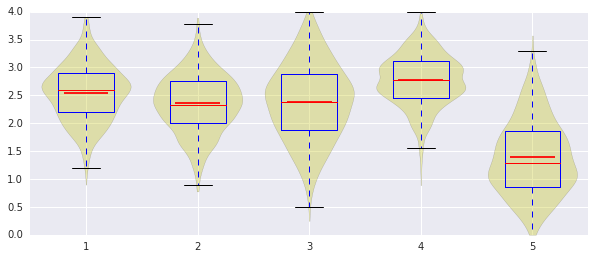

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))

# generate some random test data
all_data = []
for trait in ['O', 'C', 'E', 'A', 'N']:
    all_data.append([u[trait] for u in dataset.values()])

# plot violin plot
plt.violinplot(all_data,
               showmeans=True,
               showmedians=False,
               showextrema=False,
               widths=0.8)

# plot box plot
plt.boxplot(all_data)

plt.show()

In [54]:
min(all_data[4])

0.0

In [18]:
X = []
for dp in dataset:
    X.append([dp[f] for f in featurevector])
    
X = np.array(X)

In [19]:
np.savetxt("../data/big_five.csv", X, delimiter=",")

In [20]:
df = pd.DataFrame(X)

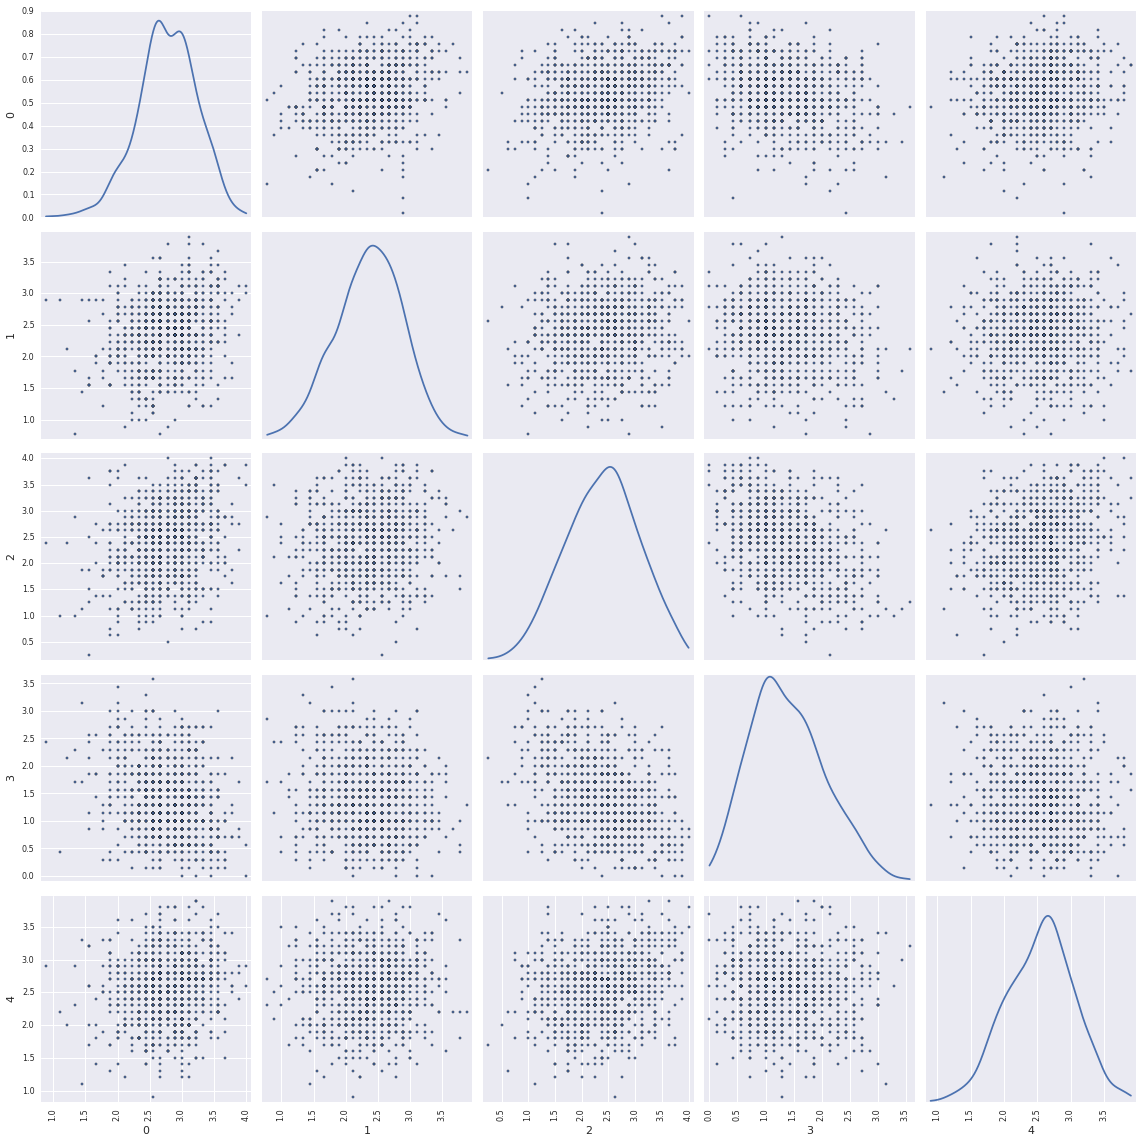

In [21]:
df = pd.DataFrame(X)
pd.tools.plotting.scatter_matrix(df, alpha=1, figsize=(16,16), diagonal="kde")
plt.tight_layout()
plt.show()

In [22]:
model = NMF(n_components=5, init='random', random_state=0)
X_NMF = model.fit(X) 

In [23]:
print X_NMF.components_

[[ 3.59422822  0.          0.          1.95538755  3.51542041]
 [ 2.66324611  3.11650427  0.          0.          0.        ]
 [ 0.          1.35880509  0.3454905   2.97388785  0.39262192]
 [ 3.16424764  0.          5.38097631  0.          0.        ]
 [ 0.41996881  0.93768846  1.12920175  0.          1.78099567]]


In [30]:
class Big_five_extractor:
    
    def __init__(self, token):
        dat = rq.get("https://www.sensible.dtu.dk/sensible-dtu/connectors/connector_answer/v1/aggregate_questionnaire_question/get_aggregated_questionnaire_data/?bearer_token=%s&format=json&decrypted=false&form_version=90920167766cb9d5d5767b692b9d3acb&sortby=timestamp&order=1&limit=1000&" % token).json()
        self.bfi_dat = dict(
            (
                response['user'][1:-1], 
                dict((k,v) for k,v in response.items() if k[:3] == "bfi")
            )
                for response in dat['results'])
        
        response_codes = {'meget_uenig': 0, 'uenig': 1, 
                          'hverken_enig_eller_uenig': 2, 
                          'enig': 3, 'meget_enig': 4}

        big5_map = {
                    "bfi_talk": {"dim": "Ex", "reversed": False},
                    "bfi_error": {"dim": "Ag", "reversed": True},
                    "bfi_work": {"dim": "Co", "reversed": False},
                    "bfi_depressed": {"dim": "Ne", "reversed": False},
                    "bfi_original": {"dim": "OE", "reversed": False},
                    "bfi_reserved": {"dim": "Ex", "reversed": True},
                    "bfi_helpfull": {"dim": "Ag", "reversed": False},
                    "bfi_careless": {"dim": "Co", "reversed": True},
                    "bfi_relaxed": {"dim": "Ne", "reversed": True},
                    "bfi_currious": {"dim": "OE", "reversed": False},
                    "bfi_energi": {"dim": "Ex", "reversed": False},
                    "bfi_fight": {"dim": "Ag", "reversed": True},
                    "bfi_reliable": {"dim": "Co", "reversed": False},
                    "bfi_tense": {"dim": "Ne", "reversed": False},
                    "bfi_creative": {"dim": "OE", "reversed": False},
                    "bfi_enthusiasm": {"dim": "Ex", "reversed": False},
                    "bfi_forgive": {"dim": "Ag", "reversed": False},
                    "bfi_disorderly": {"dim": "Co", "reversed": True},
                    "bfi_worry": {"dim": "Ne", "reversed": False},
                    "bfi_imagination": {"dim": "OE", "reversed": False},
                    "bfi_quiet": {"dim": "Ex", "reversed": True},
                    "bfi_confident": {"dim": "Ag", "reversed": False},
                    "bfi_lazy": {"dim": "Co", "reversed": True},
                    "bfi_stable": {"dim": "Ne", "reversed": True},
                    "bfi_inventive": {"dim": "OE", "reversed": False},
                    "bfi_strong_personality": {"dim": "Ex", "reversed": False},
                    "bfi_cold": {"dim": "Ag", "reversed": True},
                    "bfi_hold_on": {"dim": "Co", "reversed": False},
                    "bfi_unbalanced": {"dim": "Ne", "reversed": False},
                    "bfi_art": {"dim": "OE", "reversed": False},
                    "bfi_shy": {"dim": "Ex", "reversed": True},
                    "bfi_caring": {"dim": "Ag", "reversed": False},
                    "bfi_effective": {"dim": "Co", "reversed": False},
                    "bfi_calm": {"dim": "Ne", "reversed": True},
                    "bfi_rutine": {"dim": "OE", "reversed": True},
                    "bfi_social": {"dim": "Ex", "reversed": False},
                    "bfi_rude": {"dim": "Ag", "reversed": True},
                    "bfi_nervous": {"dim": "Co", "reversed": False},
                    "bfi_play": {"dim": "OE", "reversed": False},
                    "bfi_few_art": {"dim": "OE", "reversed": True},
                    "bfi_coorporation": {"dim": "Ag", "reversed": False},
                    "bfi_distract": {"dim": "Co", "reversed": True},
                    "bfi_taste_art": {"dim": "OE", "reversed": False}
                    }
        
        dataset = {}

        for user, questions in bfi_dat.items():
            append_datapoint = True
            big5_vals = {"OE": [], "Ex": [], "Ag": [], "Co": [], "Ne": []}

            for q, a in questions.items():
                if a == u'':
                    append_datapoint = False
                    break
                dim = big5_map[q]['dim']
                rev = big5_map[q]['reversed']
                if rev:
                    big5_vals[dim].append(4-response_codes[a[1:-1]])
                else:
                    big5_vals[dim].append(response_codes[a[1:-1]])

            if append_datapoint:
                big5_vals = dict((k,np.mean(v)) for k,v in big5_vals.items())
                dataset[user] = big5_vals
                
        self.dataset = dataset
        
        
    def main(self, user):
        return self.dataset[user]



In [31]:
bf = Big_five_extractor("b68b684617bdbc5adec25ac83479e7")

In [35]:
bf.main("198c5029e3aa7630cc1b62b85b2d74")

{'Ag': 2.5555555555555554,
 'Co': 3.0,
 'Ex': 2.0,
 'Ne': 1.0,
 'OE': 2.6000000000000001}

u'198c5029e3aa7630cc1b62b85b2d74'